# Course overview

> Getting started

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np

ModuleNotFoundError: No module named 'datasets'

## Overview

Consider, we can have images at varying levels of bluriness.

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np

mnist = load_dataset("mnist")
img = np.array(mnist["train"][0]["image"])
img = normalize(img)
img_blurry = img + np.random.normal(size=img.size).reshape(28, 28) * 
img_very_blurry = img + np.random.normal(size=img.size).reshape(28, 28) * 0.8

Found cached dataset mnist (/Users/jeremiahfisher/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 521.91it/s]


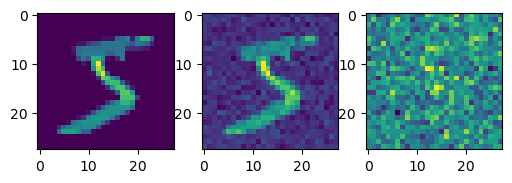

In [ ]:
#|export
def show_images(imgs, titles=None, aspect_ratio=2):
    fig, axes = plt.subplots(1, len(imgs), figsize=(aspect_ratio*len(imgs), aspect_ratio))
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if titles:
            ax.set(title=titles[i])
        ax.imshow(img)
        
imgs = [img, img_blurry, img_very_blurry]
show_images(imgs)

We can imagine a probability distribution over the image, which is a function, $P$, of $28^2$ variables (one for each pixel).

Recall that mutlivariate calculus is concerned with partial derivatives. For example, the partial derivatives of $f(x,y)=x^2 + y^2$ are:

$$
\begin{align}
\frac{\partial f(x,y)}{\partial x} &= 2x \\
\frac{\partial f(x,y)}{\partial y} &= 2y \\
\end{align}
$$

In the case of an image, imagine the partial derivative of the function $P$ with respect to a *single pixel*:

$$
\frac{\partial P(X)}{\partial X_{i,j}}
$$

This gives us a way of altering the image from less likely and blurrier images to more likely and crisper images. An algorithm could look something like this:

- For all pixel values $X_{i,j} \in X$, evaluate the partial derivative $\frac{P(X)-P(X + X_{i,j})}{\partial X_{i,j}}$ or $\frac{\partial P(X)}{\partial X_{i,j}}$. This can also be expressed as $\nabla_X P$
- For some hyperparameter constant $C$ and for all pixel values $X_{i,j} \in X$, $X_{i,j} := X_{i,j} + C \frac{\partial P(X)}{\partial X_{i,j}}$ or, equivalently, $X := X + C \cdot \nabla_X P$
- Repeat until satisfied

In PyTorch, this would look something like:

```python
X = get_image()
# Somewhat unusually, you would incorporate the image as a model
# parameter in order to get auto-differentiation
model = get_nabla_X_of_P_model(X=X)
for _ in range(n_timesteps):
	p_grad = model.forward(X)
	p_grad.backward()
	model.X += C * model.X.grad
```


In fact, we don't have $P(X)$ or $\nabla_X P(X)$ in real life. But we can solve a related problem.

Notice that $\nabla_X P(X)$ provides a direction from blurrier to sharper images. We can train a neural network to de-blur by adding the blur ourselves. The input-output pair would be $\langle image + \epsilon, \epsilon \rangle$ where $\epsilon \sim \mathcal{N}(0, \Sigma)$ and $\Sigma \in \mathbb{R}^{28^2 \times 28^2}$

## Noise Scheduling

Because Stable Diffusion originated in research in differential equations, we generally have $t$ as an input parameter. Different amounts of noise are added at different time steps.

// Add figure here

Since the amount of noise is a function of time, giving the model access to $t$ can help its performance. Therefore, the input-output pair becomes  $\langle \left( image + \epsilon, t \right), \epsilon \rangle$.

This is similiar in many respects to gradient descent. We can think of $C$ as the learning rate; the principle difference is that the model would not have access to $t$.

## Prompt Conditioning

One thing we could add to make the problem easier is to indicate the image class (1, 2, 3, etc). For a simple class distribution, we could just one hot-encode it.  The input-output pair would then be $\langle \left( image + \epsilon, t, class \right), \epsilon \rangle$.

But we cannot one-hot encode the distribution of images on the internet à la Stable Diffusion. Therefore, we need a more sophisticated encoder: CLIP (**C**onstrastively **L**earned **I**mage **P**airs). This works on the idea that the dot-product between image encoding and text encoding of the *same thing* should be small, while the image encoding and text encoding for *different things* should be larger.

We learn this with a neural network contrastively. For a given batch, $B$,  of (image, language) pairs from html `alt` tags:

- Compute the encoding $f_{image}(I_i)$ and $f_{language}(L_i)$ for all $i \in |B|$

- Compute the sum $\text{paired loss} := \Sigma_i^{|B|} f_{image}(I_i) \cdot f_{language}(L_i)$

- Compute the sum

$$
\text{unpaired loss} := \Sigma_i^{|B|} \Sigma_j^{|B|}  \begin{cases}
    f_{image}(I_i) \cdot f_{language}(L_j) & i \neq j\\
    0 & i = j
  \end{cases}
$$

- Final loss = `paired loss` - `unpaired loss`. Note that we *want* paired loss to be small and unpaired loss to be big.

## VAE Pre-/post-processing

Another thing we can do is, instead of training directly on pixel values, use the latents of a Variational Autoencoder (VAE). This can give a dramatic reduction in the number of parameters to train.

// Add figure




- Stable Diffusion
  - Guidance scale modulates the degree of fidelity to the prompt
  - Img2Img allows the squishing of one image style into another
  - Fine-tuning:
      - Same vocab, [fine-tuned weights](https://lambdalabs.com/blog/how-to-fine-tune-stable-diffusion-how-we-made-the-text-to-pokemon-model-at-lambda)
      - New vocab, frozen weights: [Textual inversion](https://huggingface.co/docs/diffusers/training/text_inversion)
      - New vocab, fine-tuned weights: [Dreambooth](https://dreambooth.github.io)
  
## Advice

- GPUs might be worth investing in

## To-do

- [ ] unchecked

## Reading & Exploration

- https://colab.research.google.com/github/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb#scrollTo=lWwG1r9j5NnE
- https://lambdalabs.com/blog/how-to-fine-tune-stable-diffusion-how-we-made-the-text-to-pokemon-model-at-lambda

## Questions

- Proper notation for 
